In [ ]:
!pip install transformers datasets
!sudo apt-get install git-lfs
!pip install apache_beam mwparserfromhell
!pip install creolenltk
!pip install accelerate -U

In [3]:
from huggingface_hub import notebook_login
from datasets import concatenate_datasets, load_dataset, Dataset
from google.colab import drive
from huggingface_hub import HfApi
import torch
import re
from bs4 import BeautifulSoup
from creolenltk.contraction_expansion import ContractionToExpansion
from tokenizers import ByteLevelBPETokenizer
import os
from transformers import RobertaConfig, RobertaTokenizer, RobertaForMaskedLM, LineByLineTextDataset, DataCollatorForLanguageModeling, Trainer, TrainingArguments
import matplotlib.pyplot as plt

In [ ]:
notebook_login()

## 1. Prepare the dataset

### Load the datasets

In [4]:
# Load different data
drive.mount('/content/gdrive/', force_remount=True)

with open("gdrive/MyDrive/HaiRoBERT/data/data.txt", "r") as f:
    data = [re.sub(r'\s+([.,?!])', r'\1', line.rstrip('\n')) for line in f if len(line) > 1 and line.strip()]

Mounted at /content/gdrive/


In [5]:
# Create a dataset
raw_datasets = Dataset.from_dict({"text": data})
raw_datasets

Dataset({
    features: ['text'],
    num_rows: 183084
})

In [6]:
raw_datasets['text'][:10]

['Bibliyotèk sou entènèt',
 'Nou kontan ou vin sou sit sa a.',
 'Se yon zouti ki pèmèt nou fè rechèch nan divès lang nan piblikasyon temwen jewova yo.',
 'Pou ou kapab telechaje piblikasyon yo, ale sou lyen sa.',
 'Lendi 11 mas.',
 'Jezi te konnen sa ki nan lòm.',
 'Jezi te byen aji ak toule 12 apot yo e li te montre li renmen yo.',
 'Ki leson nou aprann?',
 'Menmsi nou gen rezon pou nou fache akoz sa lòt moun fè, nou dwe fè atansyon ak fason nou reyaji lè yo fè erè.',
 'Lè yon frè oswa yon sè fè yon bagay ki fè nou fache, nou kapab mande tèt nou poukisa sa li fè a kontrarye mwen konsa?']

### Preprocessing

In [7]:
def preprocess_text(example):
    text = example['text']

    # Remove HTML tags
    soup = BeautifulSoup(text, 'html.parser')
    text = re.sub(r'<.*?>', '', soup.get_text())

    # Remove non-alphabetic characters
    cleaned_text = re.sub(r'[^a-zA-Zàèò\s,.!?]+', ' ', text)

    # Remove extra whitespaces
    cleaned_text = re.sub(' +', ' ', cleaned_text)

    # Expand contractions using CreoleNLTK
    expander = ContractionToExpansion()
    expanded_sentence = expander.expand_contractions(cleaned_text.strip())

     # Check if the sentence ends with '.', '?', or '!'
    if not re.search(r'[.!?]$', expanded_sentence):
        expanded_sentence += '.'

    example['text'] = expanded_sentence.capitalize()

    return example

In [8]:
# Apply preprocessing to the raw_datasets
preprocessed_datasets = raw_datasets.map(preprocess_text)
preprocessed_datasets

Map:   0%|          | 0/183084 [00:00<?, ? examples/s]

Dataset({
    features: ['text'],
    num_rows: 183084
})

In [9]:
preprocessed_datasets['text'][:10]

['Bibliyotèk sou entènèt.',
 'Nou kontan ou vin sou sit sa a.',
 'Se yon zouti ki pèmèt nou fè rechèch nan divès lang nan piblikasyon temwen jewova yo.',
 'Pou ou kapab telechaje piblikasyon yo, ale sou lyen sa.',
 'Lendi mas.',
 'Jezi te konnen sa ki nan lòm.',
 'Jezi te byen aji ak toule apot yo e li te montre li renmen yo.',
 'Ki leson nou aprann?',
 'Menmsi nou gen rezon pou nou fache akoz sa lòt moun fè, nou dwe fè atansyon ak fason nou reyaji lè yo fè erè.',
 'Lè yon frè oswa yon sè fè yon bagay ki fè nou fache, nou kapab mande tèt nou poukisa sa li fè a kontrarye mwen konsa?']

In [10]:
# Define the file path for the output file
data_path = "gdrive/MyDrive/HaiRoBERT/data/preprocessed_data.txt"

with open(data_path, "w") as output_file:
    for example in preprocessed_datasets:
        output_file.write(example['text'] + "\n")


## 2. Train a Tokenizer

In [11]:
# Initialize a tokenizer
tokenizer = ByteLevelBPETokenizer()
paths = [data_path]

In [12]:
# Customize training
tokenizer.train(files=paths, vocab_size=52_000, min_frequency=2, special_tokens=[
    "<s>",
    "<pad>",
    "</s>",
    "<unk>",
    "<mask>",
])

In [13]:
# Save files to drive
token_dir = 'gdrive/MyDrive/HaiRoBERT/model'

if not os.path.exists(token_dir):
 os.makedirs(token_dir)

tokenizer.save_model(directory=token_dir)

['gdrive/MyDrive/HaiRoBERT/model/vocab.json',
 'gdrive/MyDrive/HaiRoBERT/model/merges.txt']

## 3. Preprocess the dataset

In [14]:
#Define the configuration of the Model
config = RobertaConfig(
 vocab_size=52_000,
 max_position_embeddings=514,
 num_attention_heads=12,
 num_hidden_layers=12,
 type_vocab_size=1,
)

In [15]:
# Load trained tokenizer
tokenizer = RobertaTokenizer.from_pretrained(token_dir, max_length=512)

In [16]:
# Initialize the Model
model = RobertaForMaskedLM(config=config).cuda()

In [17]:
# Build the Dataset
dataset = LineByLineTextDataset(
 tokenizer=tokenizer,
 file_path=data_path,
 block_size=128,
)

/usr/local/lib/python3.10/dist-packages/transformers/data/datasets/language_modeling.py:119: FutureWarning: This dataset will be removed from the library soon, preprocessing should be handled with the 🤗 Datasets library. You can have a look at this example script for pointers: https://github.com/huggingface/transformers/blob/main/examples/pytorch/language-modeling/run_mlm.py
  warnings.warn(


In [18]:
# Define the Data Collator
data_collator = DataCollatorForLanguageModeling(
 tokenizer=tokenizer, mlm=True, mlm_probability=0.15
)

## 4. Pre-train the model

In [19]:
training_args = TrainingArguments(
 output_dir=token_dir,
 overwrite_output_dir=True,
 num_train_epochs=3,
 per_device_train_batch_size=64,
 save_steps=10_000,
 save_total_limit=2,
)

trainer = Trainer(
 model=model,
 args=training_args,
 data_collator=data_collator,
 train_dataset=dataset,
)

trainer.train()

/usr/local/lib/python3.10/dist-packages/accelerate/accelerator.py:432: FutureWarning: Passing the following arguments to `Accelerator` is deprecated and will be removed in version 1.0 of Accelerate: dict_keys(['dispatch_batches', 'split_batches', 'even_batches', 'use_seedable_sampler']). Please pass an `accelerate.DataLoaderConfiguration` instead: 
dataloader_config = DataLoaderConfiguration(dispatch_batches=None, split_batches=False, even_batches=True, use_seedable_sampler=True)
  warnings.warn(


Step,Training Loss
500,5.738800
1000,4.666900
1500,4.211900
2000,3.830400
2500,3.610400
3000,3.450600
3500,3.312600
4000,3.217000
4500,3.124800
5000,3.050900


Step,Training Loss
500,5.738800
1000,4.666900
1500,4.211900
2000,3.830400
2500,3.610400
3000,3.450600
3500,3.312600
4000,3.217000
4500,3.124800
5000,3.050900


TrainOutput(global_step=8583, training_loss=3.426395768707037, metrics={'train_runtime': 2737.3985, 'train_samples_per_second': 200.647, 'train_steps_per_second': 3.135, 'total_flos': 1.974375660488064e+16, 'train_loss': 3.426395768707037, 'epoch': 3.0})

In [20]:
# Save the Model
trainer.save_model(token_dir)

## Test The Model

In [21]:
from transformers import pipeline
pipe = pipeline(
 'fill-mask',
 model=token_dir,
 tokenizer=token_dir
)

In [27]:
pipe("Li pa vle <mask>.")

[{'score': 0.37219974398612976,
  'token': 317,
  'token_str': ' di',
  'sequence': 'Li pa vle di.'},
 {'score': 0.06567823886871338,
  'token': 292,
  'token_str': ' sa',
  'sequence': 'Li pa vle sa.'},
 {'score': 0.0490352027118206,
  'token': 763,
  'token_str': ' anyen',
  'sequence': 'Li pa vle anyen.'},
 {'score': 0.013163838535547256,
  'token': 299,
  'token_str': ' fè',
  'sequence': 'Li pa vle fè.'},
 {'score': 0.01286068931221962,
  'token': 394,
  'token_str': ' pè',
  'sequence': 'Li pa vle pè.'}]

In [26]:
pipe("Paris se <mask> Frans.")

[{'score': 0.6500425338745117,
  'token': 278,
  'token_str': ' te',
  'sequence': 'Paris se te Frans.'},
 {'score': 0.04836620017886162,
  'token': 309,
  'token_str': ' yon',
  'sequence': 'Paris se yon Frans.'},
 {'score': 0.016526486724615097,
  'token': 294,
  'token_str': ' pa',
  'sequence': 'Paris se pa Frans.'},
 {'score': 0.013474306091666222,
  'token': 395,
  'token_str': ' pitit',
  'sequence': 'Paris se pitit Frans.'},
 {'score': 0.008990018628537655,
  'token': 291,
  'token_str': ' pou',
  'sequence': 'Paris se pou Frans.'}]

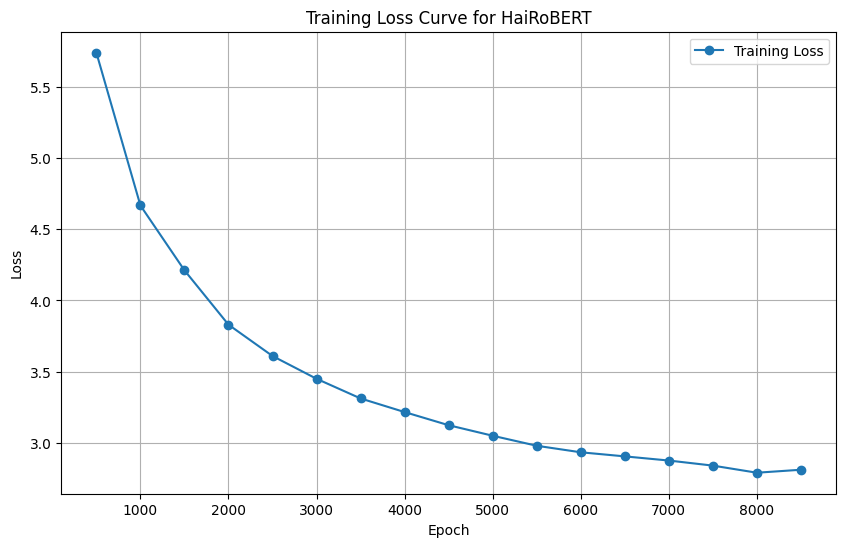

In [24]:
# Plot the training loss
loss_results = trainer.state.log_history
losses = [result["loss"] for result in loss_results[:-1]]
steps = [result["step"] for result in loss_results[:-1]]

plt.figure(figsize=(10, 6))
plt.plot(steps, losses, marker='o', label='Training Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve for HaiRoBERT')
plt.grid(True)
plt.legend()
plt.show()